In [13]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.6 kB/s s eta 0:00:01     |███████████████████████▎        | 511.2 MB 105.5 MB/s eta 0:00:02     |██████████████████████████      | 570.0 MB 41.7 MB/s eta 0:00:04
     |████████████████████████████████| 6.6 MB 65.8 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
You shou

In [15]:
%cd mmdetection

[Errno 2] No such file or directory: 'mmdetection'
/home/ubuntu/ssl/mmdetection


In [16]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.14.0
10.1
GCC 9.3


In [17]:
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import torch 

In [6]:
# Unzip the GPR data ad restructure the files to match the paths below
!unzip GPR_public_with_annotations.coco2.zip -d GPR/

Archive:  GPR_public_with_annotations.coco2.zip
   creating: GPR/GPR_public_with_annotations.coco/
  inflating: GPR/__MACOSX/._GPR_public_with_annotations.coco  
  inflating: GPR/GPR_public_with_annotations.coco/README.roboflow.txt  
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/._README.roboflow.txt  
   creating: GPR/GPR_public_with_annotations.coco/valid/
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/._valid  
  inflating: GPR/GPR_public_with_annotations.coco/.DS_Store  
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/._.DS_Store  
   creating: GPR/GPR_public_with_annotations.coco/test/
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/._test  
   creating: GPR/GPR_public_with_annotations.coco/train/
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/._train  
  inflating: GPR/GPR_public_with_annotations.coco/valid/_annotations.coco.json  
  inflating: GPR/__MACOSX/GPR_public_with_annotations.coco/valid/.__annotations.coco.json  

In [7]:
# Download the checkpoint per the above config from::: 
# https://github.com/open-mmlab/mmdetection/blob/master/docs/model_zoo.md
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth \
      -O checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2021-07-06 15:33:56--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [18]:
# Import the model which you want to retrain
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco.py')

In [19]:
# Change the classes in CocoDataset
cfg.dataset_type = 'CocoDataset'
cfg.classes = ('hYPERBOLA-DETECTION','hyperbola')
# number of classes
cfg.model.roi_head.bbox_head.num_classes = 2
#cfg.model.roi_head.mask_head.num_classes = 2

In [20]:
# Change the paths to the dataset and annotations
PREFIX = '/home/ubuntu/ssl/mmdetection/GPR/'
cfg.data.train.img_prefix = PREFIX+'train/Images/'
cfg.data.train.classes = cfg.classes
cfg.data.train.ann_file = PREFIX + 'train/_annotations.coco.json'
cfg.data.train.type = 'CocoDataset'
cfg.data.val.img_prefix = PREFIX+'valid/Images/'
cfg.data.val.classes = cfg.classes
cfg.data.val.ann_file = PREFIX + 'valid/_annotations.coco.json'
cfg.data.val.type = 'CocoDataset'
cfg.data.test.img_prefix = PREFIX+'test/Images/'
cfg.data.test.classes = cfg.classes
cfg.data.test.ann_file = PREFIX + 'test/_annotations.coco.json'
cfg.data.test.type = 'CocoDataset'

In [21]:
# Experiment with the hyperparameters
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 600
# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'proposal'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.load_from = 'checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth'
cfg.work_dir = "../test"
cfg.runner.max_epochs = 12
cfg.total_epochs = 12
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet101_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='C

In [23]:
model = build_detector(cfg.model)
datasets = [build_dataset(cfg.data.train)]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/ubuntu/ssl/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [24]:
# Used later for easy visualization on test dataset
model.CLASSES = datasets[0].CLASSES

In [22]:
# Train the detector
train_detector(model, datasets[0], cfg, distributed=False, validate=True)

2021-07-06 14:35:46,200 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth
2021-07-06 14:35:46,200 - mmdet - INFO - Use load_from_local loader


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-07-06 14:35:46,421 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([8]).
2021-07-06 14:35:46,426 - mmdet - INFO - Start running, host: ubuntu@ip-172-31-25-188, work_dir: /home/ubuntu/ssl/test
2021-07-06 14:35:46,428 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLr

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 34/34, 8.7 task/s, elapsed: 4s, ETA:     0s

2021-07-06 14:37:39,980 - mmdet - INFO - Evaluating proposal...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...


2021-07-06 14:37:40,047 - mmdet - INFO - Epoch(val) [3][34]	AR@100: 0.4070, AR@300: 0.4070, AR@1000: 0.4070, AR_s@1000: 0.1300, AR_m@1000: 0.4350, AR_l@1000: 0.4540


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.454


2021-07-06 14:39:17,291 - mmdet - INFO - Saving checkpoint at 6 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 34/34, 9.0 task/s, elapsed: 4s, ETA:     0s

2021-07-06 14:39:33,392 - mmdet - INFO - Evaluating proposal...
2021-07-06 14:39:33,447 - mmdet - INFO - Epoch(val) [6][34]	AR@100: 0.4480, AR@300: 0.4480, AR@1000: 0.4480, AR_s@1000: 0.1400, AR_m@1000: 0.4620, AR_l@1000: 0.5150


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxD

2021-07-06 14:41:09,985 - mmdet - INFO - Saving checkpoint at 9 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 34/34, 8.9 task/s, elapsed: 4s, ETA:     0s

2021-07-06 14:41:22,625 - mmdet - INFO - Evaluating proposal...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-07-06 14:41:22,748 - mmdet - INFO - Epoch(val) [9][34]	AR@100: 0.4980, AR@300: 0.4980, AR@1000: 0.4980, AR_s@1000: 0.0700, AR_m@1000: 0.4940, AR_l@1000: 0.6100


DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

2021-07-06 14:43:00,879 - mmdet - INFO - Saving checkpoint at 12 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 34/34, 8.7 task/s, elapsed: 4s, ETA:     0s

2021-07-06 14:43:08,163 - mmdet - INFO - Evaluating proposal...
2021-07-06 14:43:08,209 - mmdet - INFO - Epoch(val) [12][34]	AR@100: 0.5220, AR@300: 0.5220, AR@1000: 0.5220, AR_s@1000: 0.1300, AR_m@1000: 0.5210, AR_l@1000: 0.6230


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.753
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxD

/home/ubuntu/ssl/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/home/ubuntu/ssl/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/ubuntu/ssl/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


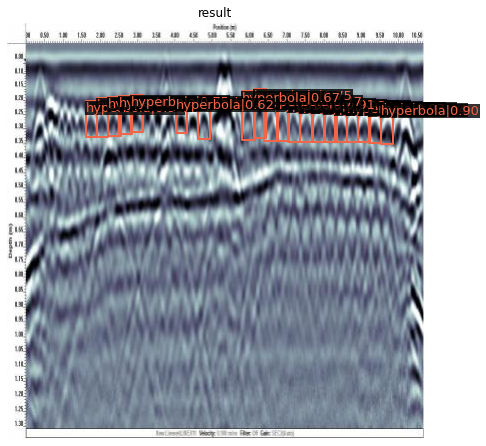

In [23]:
# Visualize the results on test dataset
import mmcv
import matplotlib.pyplot as plt
img = mmcv.imread('GPR/test/Images/3249_jpg.rf.de5c55b3df802f9666bce6e916871760.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.6)

In [12]:
%cd mmdetection

[Errno 2] No such file or directory: 'mmdetection'
/home/ubuntu/ssl/mmdetection


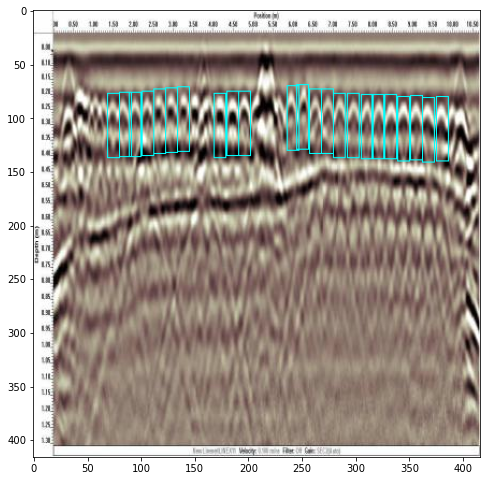

In [39]:
# Plot the image with ground truths
import json
import cv2
import os
%matplotlib inline
from matplotlib import pyplot as plt

test_file_root = "GPR/test/Images/"
json_file = "GPR/test/_annotations.coco.json"
test_image = "3249_jpg.rf.de5c55b3df802f9666bce6e916871760.jpg"

with open(json_file) as anno:
    annotations = json.load(anno)
    
images = annotations['images']
for i in range(len(images)):
    if images[i]['file_name'] == test_image:
        image_id = i
        break
        #print(image_id)
annots = annotations['annotations']
image_path = test_file_root + test_image
image = cv2.imread(image_path)
for j in range(len(annots)):
    if annots[j]['image_id'] == image_id:
        annotation = annots[j]
        bbox = annotation['bbox']
        x, y, w, h = bbox
        anno_image = cv2.rectangle(image , (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 255), 1)
plt.figure(figsize=(8,10))
plt.imshow(anno_image)
plt.show()        
    

In [33]:
%cd mmdetection

/home/ubuntu/ssl/mmdetection


In [40]:
!pwd

/home/ubuntu/ssl/mmdetection


In [23]:
classes_str='("hYPERBOLA-DETECTION","hyperbola")'
MODEL = './configs/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco.py'
CHECKPOINT = 'checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth'
!python tools/test.py\
 configs/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco.py\
 checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth\
 --cfg-options dataset_type='CocoDataset' classes=$classes_str\
 data.train.img_prefix='/home/ubuntu/ssl/mmdetection/GPR/train/Images/'\
data.train.classes='("hYPERBOLA-DETECTION","hyperbola")'\
data.train.ann_file='/home/ubuntu/ssl/mmdetectionGPR/train/_annotations.coco.json'\
data.train.type='CocoDataset'\
 data.val.img_prefix='/home/ubuntu/ssl/mmdetection/GPR/valid/Images/'\
data.val.classes='("hYPERBOLA-DETECTION","hyperbola")'\
data.val.ann_file='/home/ubuntu/ssl/mmdetection/GPR/valid/_annotations.coco.json'\
data.val.type='CocoDataset'\
 data.test.img_prefix='/home/ubuntu/ssl/mmdetection/GPR/test/Images/'\
data.test.classes=$classes_str\
data.test.ann_file='/home/ubuntu/ssl/mmdetection/GPR/test/_annotations.coco.json'\
data.test.type='CocoDataset'\
 model.bbox_head.num_classes='2' evaluation.metric='bbox' work_dir='../test' load_from=$cfg.load_from total_epochs='1' --out results.pkl

Traceback (most recent call last):
  File "tools/test.py", line 237, in <module>
    main()
  File "tools/test.py", line 107, in main
    args = parse_args()
  File "tools/test.py", line 92, in parse_args
    args = parser.parse_args()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/argparse.py", line 1734, in parse_args
    args, argv = self.parse_known_args(args, namespace)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/argparse.py", line 1766, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/argparse.py", line 1972, in _parse_known_args
    start_index = consume_optional(start_index)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/argparse.py", line 1912, in consume_optional
    take_action(action, args, option_string)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/argparse.py", line 1840, in take_action
    action(self, namespace, 

In [41]:
!python tools/test.py configs/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco.py checkpoints/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth --eval bbox --out results.pkl

Traceback (most recent call last):
  File "tools/test.py", line 15, in <module>
    from mmdet.apis import multi_gpu_test, single_gpu_test
  File "/home/ubuntu/ssl/mmdetection/mmdet/apis/__init__.py", line 1, in <module>
    from .inference import (async_inference_detector, inference_detector,
  File "/home/ubuntu/ssl/mmdetection/mmdet/apis/inference.py", line 6, in <module>
    from mmcv.ops import RoIPool
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/mmcv/ops/__init__.py", line 1, in <module>
    from .bbox import bbox_overlaps
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/mmcv/ops/bbox.py", line 3, in <module>
    ext_module = ext_loader.load_ext('_ext', ['bbox_overlaps'])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/mmcv/utils/ext_loader.py", line 12, in load_ext
    ext = importlib.import_module('mmcv.' + name)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/importlib/__init__.

In [42]:
!sudo apt\
 install g++-4.8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libaio1 librados2 librbd1
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  cpp-4.8 gcc-4.8 gcc-4.8-base libasan0 libgcc-4.8-dev libstdc++-4.8-dev
Suggested packages:
  gcc-4.8-locales g++-4.8-multilib gcc-4.8-doc libstdc++6-4.8-dbg
  gcc-4.8-multilib libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg
  libasan0-dbg libtsan0-dbg libquadmath0-dbg libstdc++-4.8-doc
The following NEW packages will be installed:
  cpp-4.8 g++-4.8 gcc-4.8 gcc-4.8-base libasan0 libgcc-4.8-dev
  libstdc++-4.8-dev
0 upgraded, 7 newly installed, 0 to remove and 11 not upgraded.
Need to get 29.3 MB of archives.
After this operation, 73.2 MB of additional disk space will be used.
Do you want to continue? [Y/n] ^C
